In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets, ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import MinMaxScaler

In [2]:
data=pd.read_csv('datacleaned.csv')
data=data.drop(['Unnamed: 0'], axis=1)

In [3]:
playerlist=list(data['playerid'].unique())

In [4]:
pointsdict={}
fdrdict={}
for i in playerlist:
    ptslist=[]
    fdrlist=[]
    selection=data[data['playerid']==i]
    for gw in range(1,39):
        ptslist.append(selection[selection['GW']==gw].iloc[0]['total_points'])
        fdrlist.append(selection[selection['GW']==gw].iloc[0]['fdr'])
    pointsdict[i]=ptslist
    fdrdict[i]=fdrlist

In [5]:
data.insert(0, 'prevscore', 0)
data.insert(0, 'prevfdr', 0)
data.insert(0, 'prev2score', 0)
data.insert(0, 'prev2fdr', 0)
data.insert(0, 'prev3score', 0)
data.insert(0, 'prev3fdr', 0)
data.insert(0, 'team_goals_scored', 0)
data.insert(0, 'team_goals_conceded', 0)

In [6]:
def kernel(scores:list)->int:
    if(len(scores)==1):
        return scores[0]*3
    if(len(scores)==2):
        return scores[0]*2+scores[1]*3
    weights=[1,2,3]
    return sum([x*y for x,y in zip(scores,weights)])

In [7]:
def fixture_finder(team1, team2, data):
    teamdict={1:'ARS', 2:'AVL',3:'BOU', 4:'BHA', 5:'BUR', 6:'CHE', 7:'CRY', 8:'EVE', 9:'LEI', 10:'LIV', 11:'MCI', 12:'MUN',
          13:'NEW', 14:'NOR', 15:'SHU', 16:'SOU', 17:'TOT', 18:'WAT', 19:'WHU', 20:'WOL'}
    rev_team = {v: k for k, v in teamdict.items()}
    t1code=rev_team[team1]
    t2code=rev_team[team2]
    selection=data[(data['team']==t1code) & (data['opponent_team']==t2code)]
    return selection

In [8]:
prevscorelist = []
prev2scorelist = []
prev3scorelist = []
prevfdrlist = []
prev2fdrlist = []
prev3fdrlist = []
goals_scored = []
goals_conceded = []

for index, row in data.iterrows():
    currgw=row['GW']
        
    if currgw==1:
        prevscorelist.append(0)
        prevfdrlist.append(-1)
    else:
        prevscorelist.append(pointsdict[row['playerid']][currgw-2])
        prevfdrlist.append(fdrdict[row['playerid']][currgw-2])
    
    if currgw in [1,2]:
        prev2scorelist.append(0)
        prev2fdrlist.append(-1)
    else:
        prev2scorelist.append(pointsdict[row['playerid']][currgw-3])
        prev2fdrlist.append(fdrdict[row['playerid']][currgw-3])
    
    if currgw in [1,2,3]:
        prev3scorelist.append(0)
        prev3fdrlist.append(-1)
    else:
        prev3scorelist.append(pointsdict[row['playerid']][currgw-4])
        prev3fdrlist.append(fdrdict[row['playerid']][currgw-4])
    
    if row['was_home']:
        goals_scored.append(row['team_h_score'])
        goals_conceded.append(row['team_a_score'])
    else:
        goals_scored.append(row['team_a_score'])
        goals_conceded.append(row['team_h_score'])

In [9]:
data['prevscore']=prevscorelist
data['prev2score']=prev2scorelist
data['prev3score']=prev3scorelist
data['prevfdr']=prevfdrlist
data['prev2fdr']=prev2fdrlist
data['prev3fdr']=prev3fdrlist
data['team_goals_scored']=goals_scored
data['team_goals_conceded']=goals_conceded

In [10]:
goalscoring_form=[]
defensive_form=[]
for i in playerlist:
    selection=data[data['playerid']==i]
    for gw in range(1,39):
        if gw==1:
            goalscoring_form.append(0)
            defensive_form.append(0)
        else:
            st_gw=max(1,gw-3)
            sco=[selection[(selection['playerid']==i)&(selection['GW']==x)].iloc[0]['team_goals_scored'] for x in range(st_gw, gw)]
            con=[selection[(selection['playerid']==i)&(selection['GW']==x)].iloc[0]['team_goals_conceded'] for x in range(st_gw, gw)]
            goalscoring_form.append(kernel(sco))
            defensive_form.append(-1*kernel(con))

In [11]:
data['att_form']=goalscoring_form
data['def_form']=defensive_form

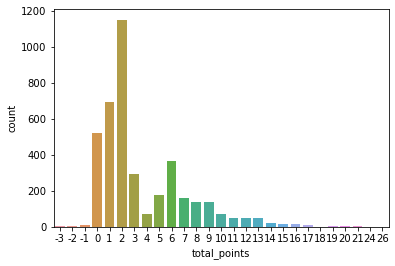

In [12]:
sns.countplot(data['total_points'])

In [14]:
data.columns

Index(['team_goals_conceded', 'team_goals_scored', 'prev3fdr', 'prev3score',
       'prev2fdr', 'prev2score', 'prevfdr', 'prevscore', 'team', 'playerid',
       'name', 'assists', 'clean_sheets', 'creativity', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'minutes', 'opponent_team',
       'round', 'saves', 'team_a_score', 'team_h_score', 'threat',
       'total_points', 'value', 'was_home', 'yellow_cards', 'GW', 'fdr',
       'att_form', 'def_form'],
      dtype='object')

In [15]:
feature_cols=['team', 'opponent_team', 'att_form', 'def_form',
              'was_home', 'fdr', 'prevscore', 'prev2score', 
              'prev3score', 'prevfdr', 'prev2fdr', 'prev3fdr']

In [16]:
targets=data['total_points']
data=data[feature_cols]

#### Scaling

In [18]:
data['fdr']-=min(data['fdr'])
data['fdr']/=max(data['fdr'])

In [24]:
data['att_form']-=min(data['att_form'])
data['att_form']/=max(data['att_form'])
data['def_form']-=min(data['def_form'])
data['def_form']/=max(data['def_form'])

In [33]:
data

,team,opponent_team,att_form,def_form,was_home,fdr,prevscore,prev2score,prev3score,prevfdr,prev2fdr,prev3fdr
0,1,13,0.00000,1.000000,False,0.500000,0,0,0,-1.0,-1.0,-1.0
1,1,13,0.09375,1.000000,False,0.500000,0,0,0,-1.0,-1.0,-1.0
2,1,13,0.25000,0.909091,False,0.500000,0,0,0,-1.0,-1.0,-1.0
3,2,17,0.25000,0.666667,False,0.833333,0,0,0,-1.0,-1.0,-1.0
4,3,18,0.31250,0.606061,False,0.500000,0,0,0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4023,1,18,0.75000,0.818182,True,0.500000,1,2,1,2.0,5.0,4.0
4024,3,8,0.68750,0.878788,False,0.666667,11,1,3,3.0,5.0,3.0
4025,4,5,0.53125,0.757576,False,0.666667,2,9,1,2.0,3.0,5.0
4026,18,1,0.40625,0.878788,False,0.666667,2,2,5,5.0,2.0,2.0


In [28]:
xtrain, xtest, ytrain, ytest=train_test_split(data, targets, test_size=0.2)

#### todo
- test on handpicked fixtures
- nailedness
- team value constraints
- ict

In [29]:
reg = ensemble.RandomForestRegressor(n_estimators=500)
reg.fit(xtrain, ytrain)

mse = mean_squared_error(ytest, reg.predict(xtest))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 11.3041


In [30]:
print(reg.feature_importances_)
print(feature_cols)

[0.11752186 0.08727394 0.13282842 0.12053658 0.02023593 0.04837317
 0.11081338 0.10221424 0.09863484 0.05222691 0.05288796 0.05645278]
['team', 'opponent_team', 'att_form', 'def_form', 'was_home', 'fdr', 'prevscore', 'prev2score', 'prev3score', 'prevfdr', 'prev2fdr', 'prev3fdr']


In [31]:
ada = ensemble.AdaBoostRegressor(n_estimators=500)
ada.fit(xtrain, ytrain)

mse = mean_squared_error(ytest, ada.predict(xtest))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 13.5715


In [32]:
print(ada.feature_importances_)
print(feature_cols)

[0.09479671 0.02124549 0.06592966 0.05380981 0.02235749 0.22817015
 0.20115195 0.14683557 0.12738956 0.00553589 0.01026355 0.02251417]
['team', 'opponent_team', 'att_form', 'def_form', 'was_home', 'fdr', 'prevscore', 'prev2score', 'prev3score', 'prevfdr', 'prev2fdr', 'prev3fdr']
